In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.signal import butter,lfilter

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_predict

from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
import arch


In [2]:
DATA_PATH = os.path.join(os.path.abspath('../../'), 'db', 'data')
PRIMARY_PATH = os.path.join(DATA_PATH, 'primary')
SECONDARY_PATH = os.path.join(DATA_PATH, 'secondary')
TERTIARY_PATH = os.path.join(DATA_PATH, 'tertiary')

wpath = os.path.join(DATA_PATH, 'merge')

# 1. Low Pass filter to smoothen the data

In [3]:
# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(data, cutoff, fs, order):
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilter(b, a, data)
    return y

In [4]:
#Curency indexes dataframe currency and limited nr of rows
raw = pd.read_csv(os.path.join(wpath, os.path.basename(TERTIARY_PATH), 'logs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')
print(f'Unique values in columns:\n{raw.nunique()}\n------------\n')

raw = raw[:2000]

Unique values in columns:
AUD    111804
CAD    111743
CHF    111761
EUR    111803
GBP    111750
JPY    111774
NZD    111797
USD    111909
dtype: int64
------------



# 2. Split smoothed Data into train and test data

In [5]:
df = pd.DataFrame(butter_lowpass_filter(raw, cutoff, fs, order), index=raw.index, columns=raw.columns)
split = int(len(df.index)/10)        # 2000/10 = 200 is enough for test
split

200

In [506]:
# Conduct the split
train = pd.DataFrame(df[:-split], index=raw.index, columns=raw.columns).dropna()
test = pd.DataFrame(df[-split:], index=raw.index, columns=raw.columns).dropna()
train.index = pd.to_datetime(train.index).to_period('H').to_timestamp().values
test.index = pd.to_datetime(test.index).to_period('H').to_timestamp().values

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


In [489]:
test.head()

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
2005-04-12 01:00,0.000307,-0.000286,-0.001296,0.001158,0.006833,0.010848,0.010555,0.006721
2005-04-12 02:00,0.000802,0.003055,0.003685,-0.000384,-0.006163,-0.009124,-0.007061,-0.001784
2005-04-12 03:00,-0.001721,-0.003975,-0.002853,-0.000241,0.001151,0.001054,-0.001331,-0.003472
2005-04-12 04:00,0.000337,0.000196,-0.001368,-0.002504,-0.001956,-0.001543,-0.001202,0.000507
2005-04-12 05:00,0.000893,0.002946,0.003517,0.000911,-0.003058,-0.006339,-0.007316,-0.005009


# 3. GOAL: Garch + ARIMA combined (often best practice)
![Red: ARMA, Green: Garch](https://miro.medium.com/max/862/1*azEK9WckHXBx73L8bTPu6Q.png) Red: ARMA, Green: Garch

Text(0.5, 1.0, '1st Order Differencing')

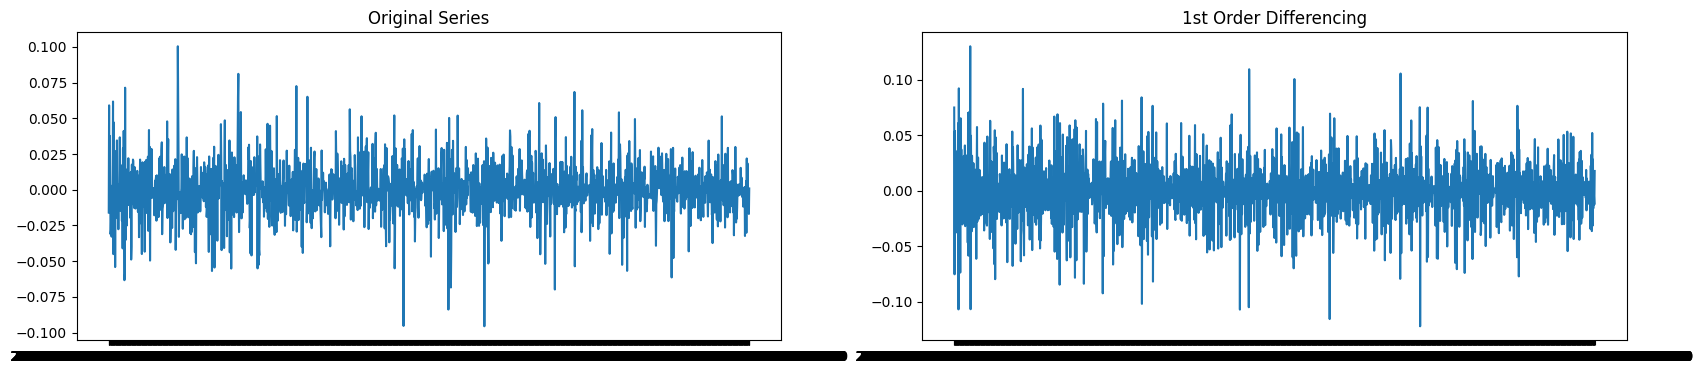

In [278]:
zero_diff = train.EUR
first_order_diff = train.EUR.diff(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,4))
ax1.plot(zero_diff); ax1.set_title('Original Series')
ax2.plot(first_order_diff); ax2.set_title('1st Order Differencing')

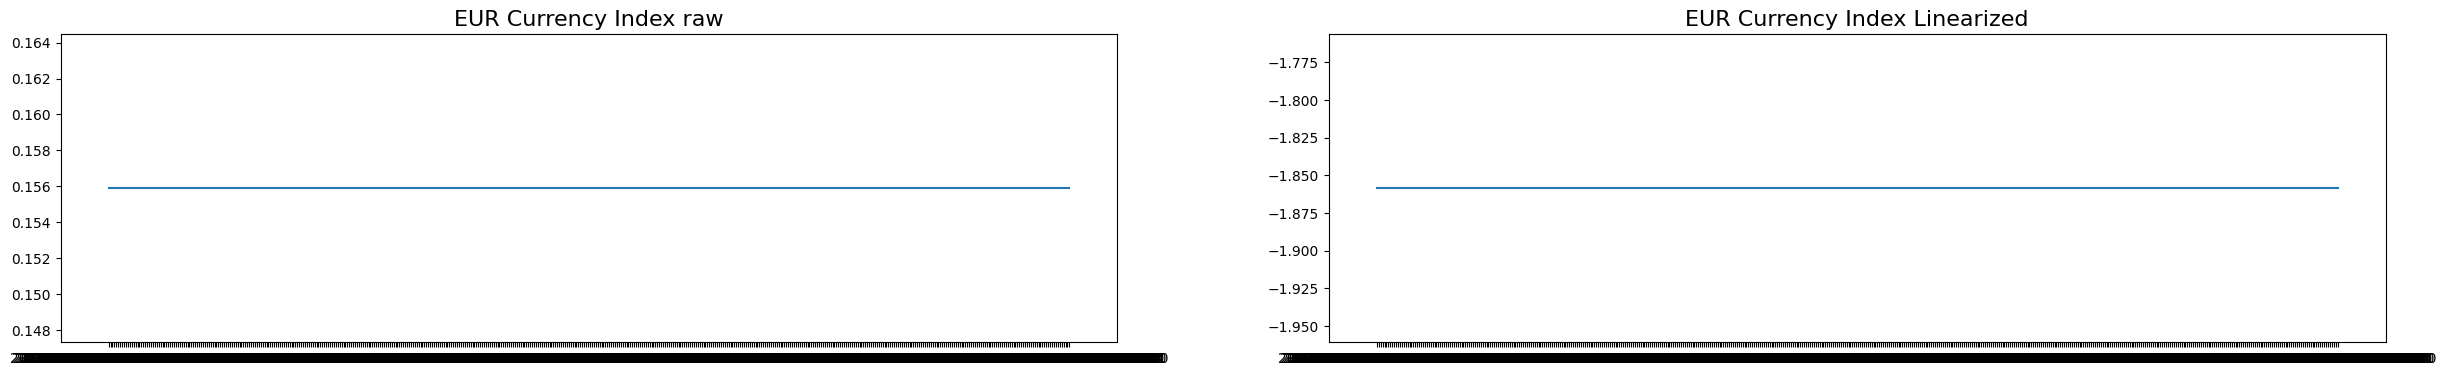

In [34]:
# Remove exponential trend for EUR
plt.figure(figsize=(30,4));
plt.subplot(1,2,1); plt.plot(train.EUR);
plt.title('EUR Currency Index', fontsize=16);

train['EUR_linear'] = np.log(train.EUR)
plt.subplot(1,2,2); plt.plot(train['EUR_linear']);
plt.title('EUR Currency Index Linearized', fontsize=16);

# check correlation plots

In [314]:
from statsmodels.tsa.stattools import adfuller

for column in df.columns:
    print(adfuller(df[column])[1]) # p-value
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


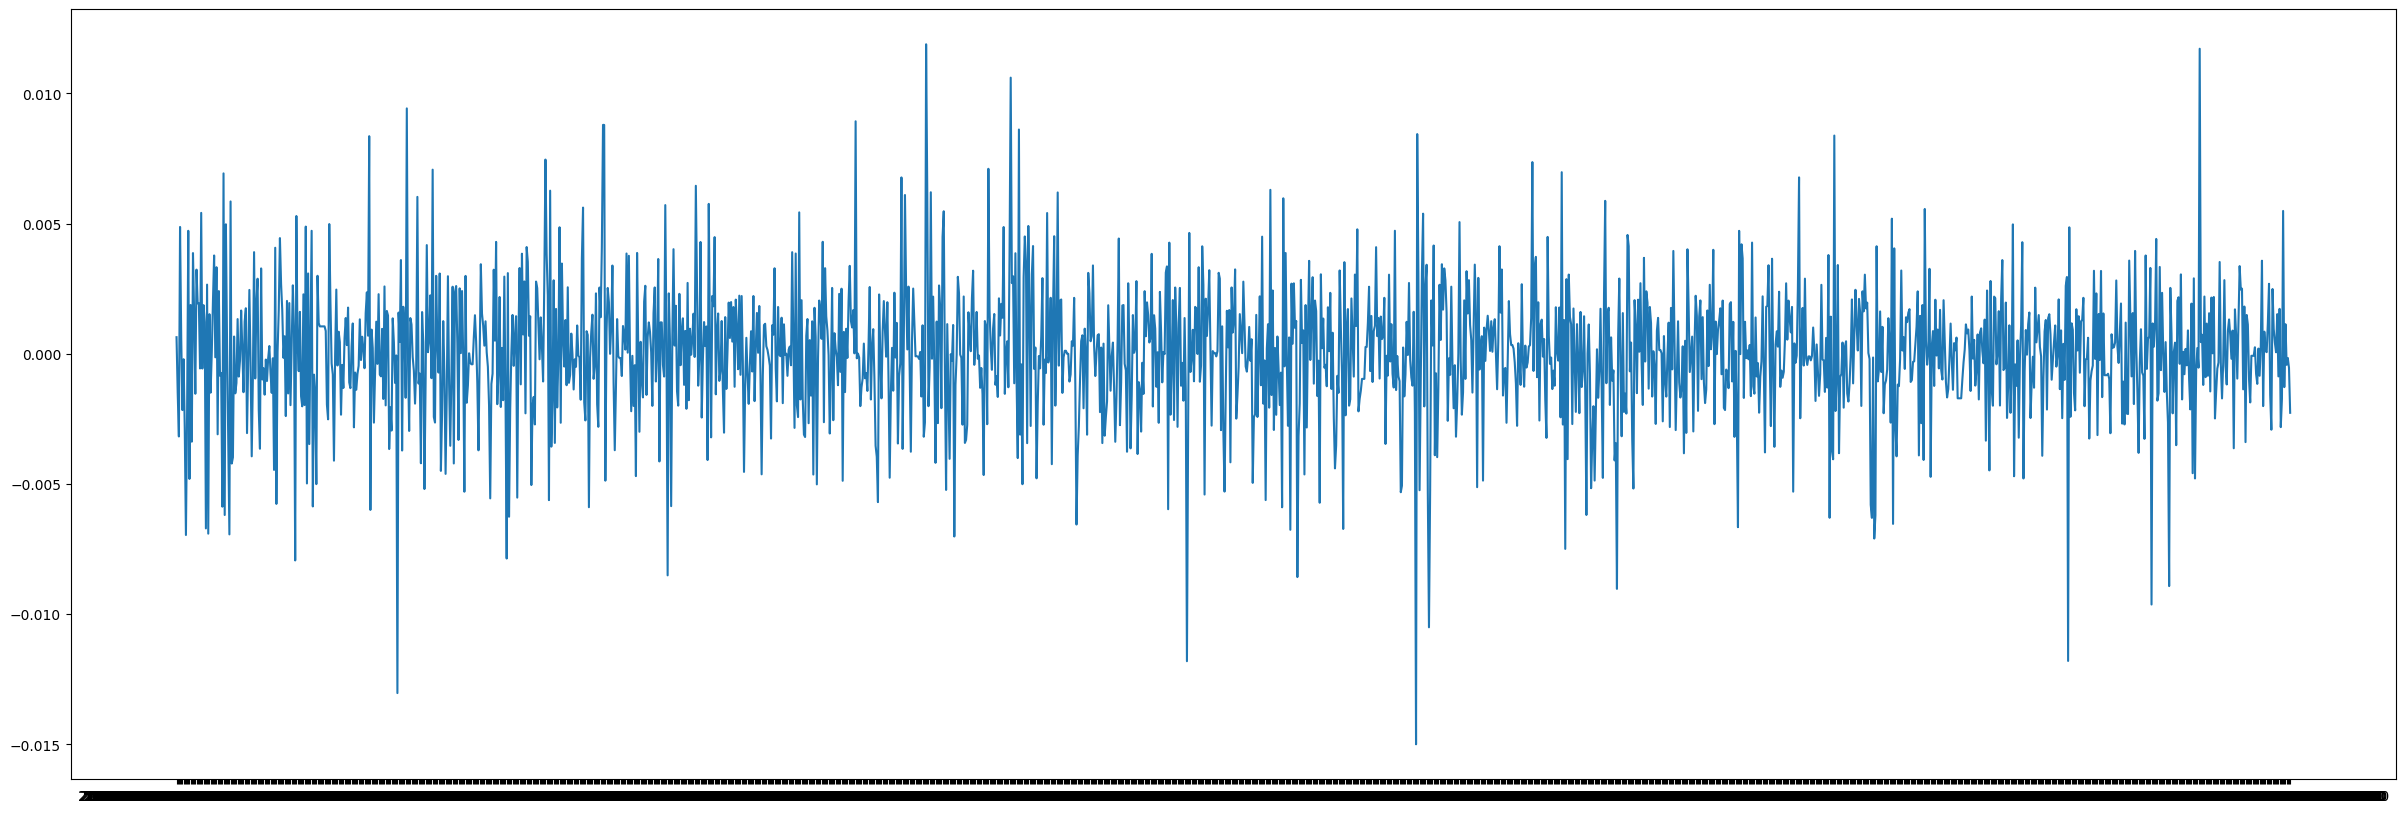

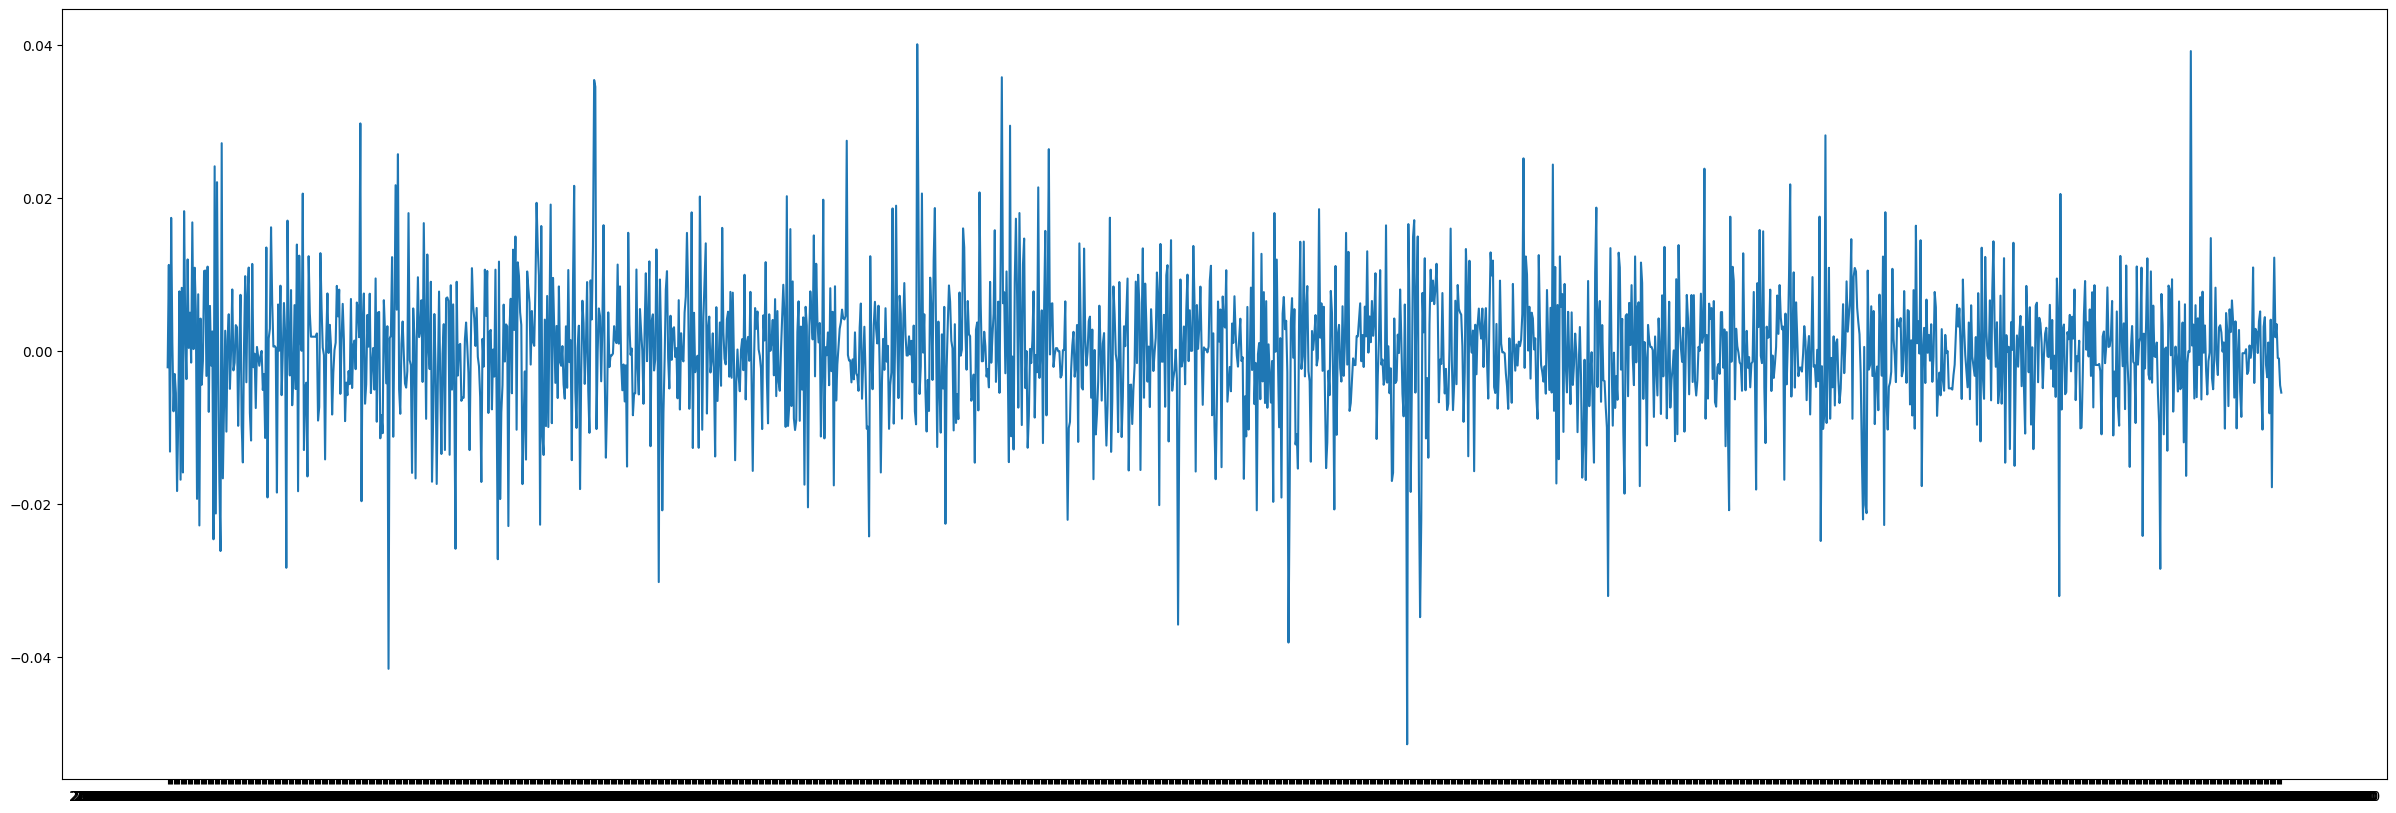

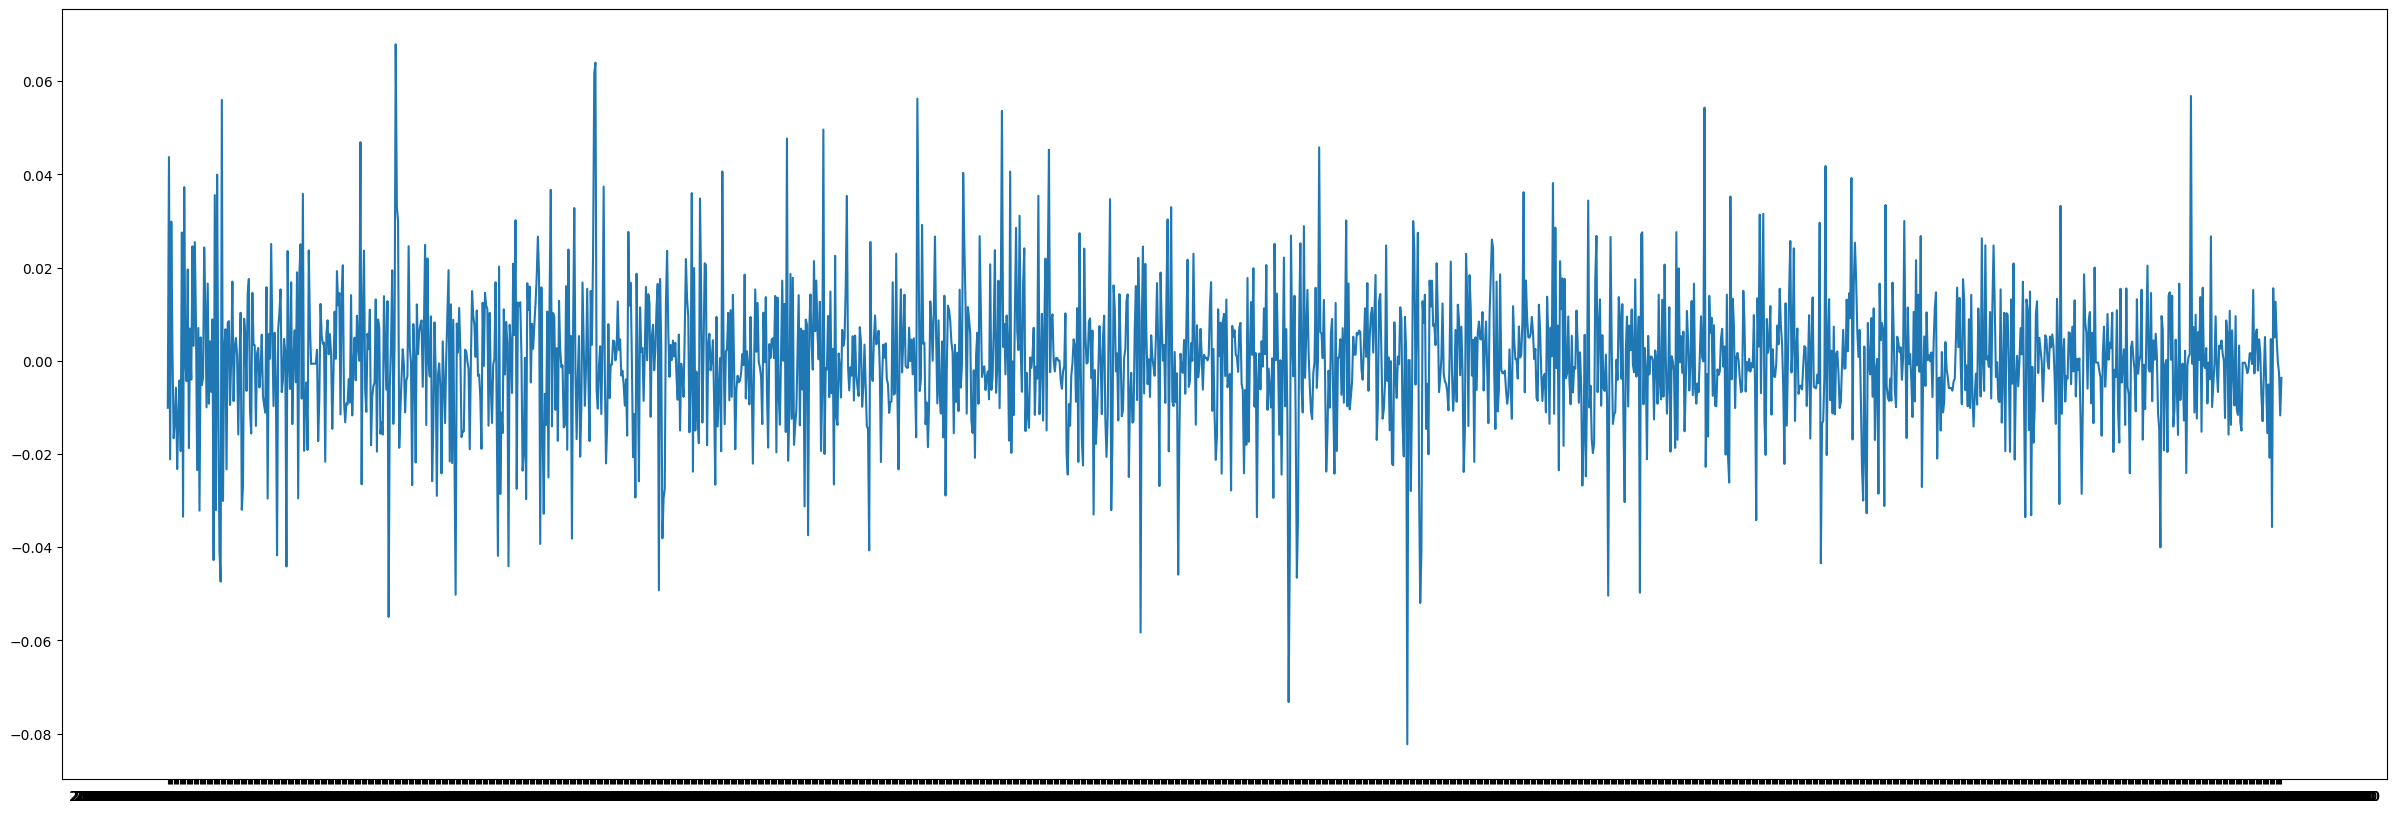

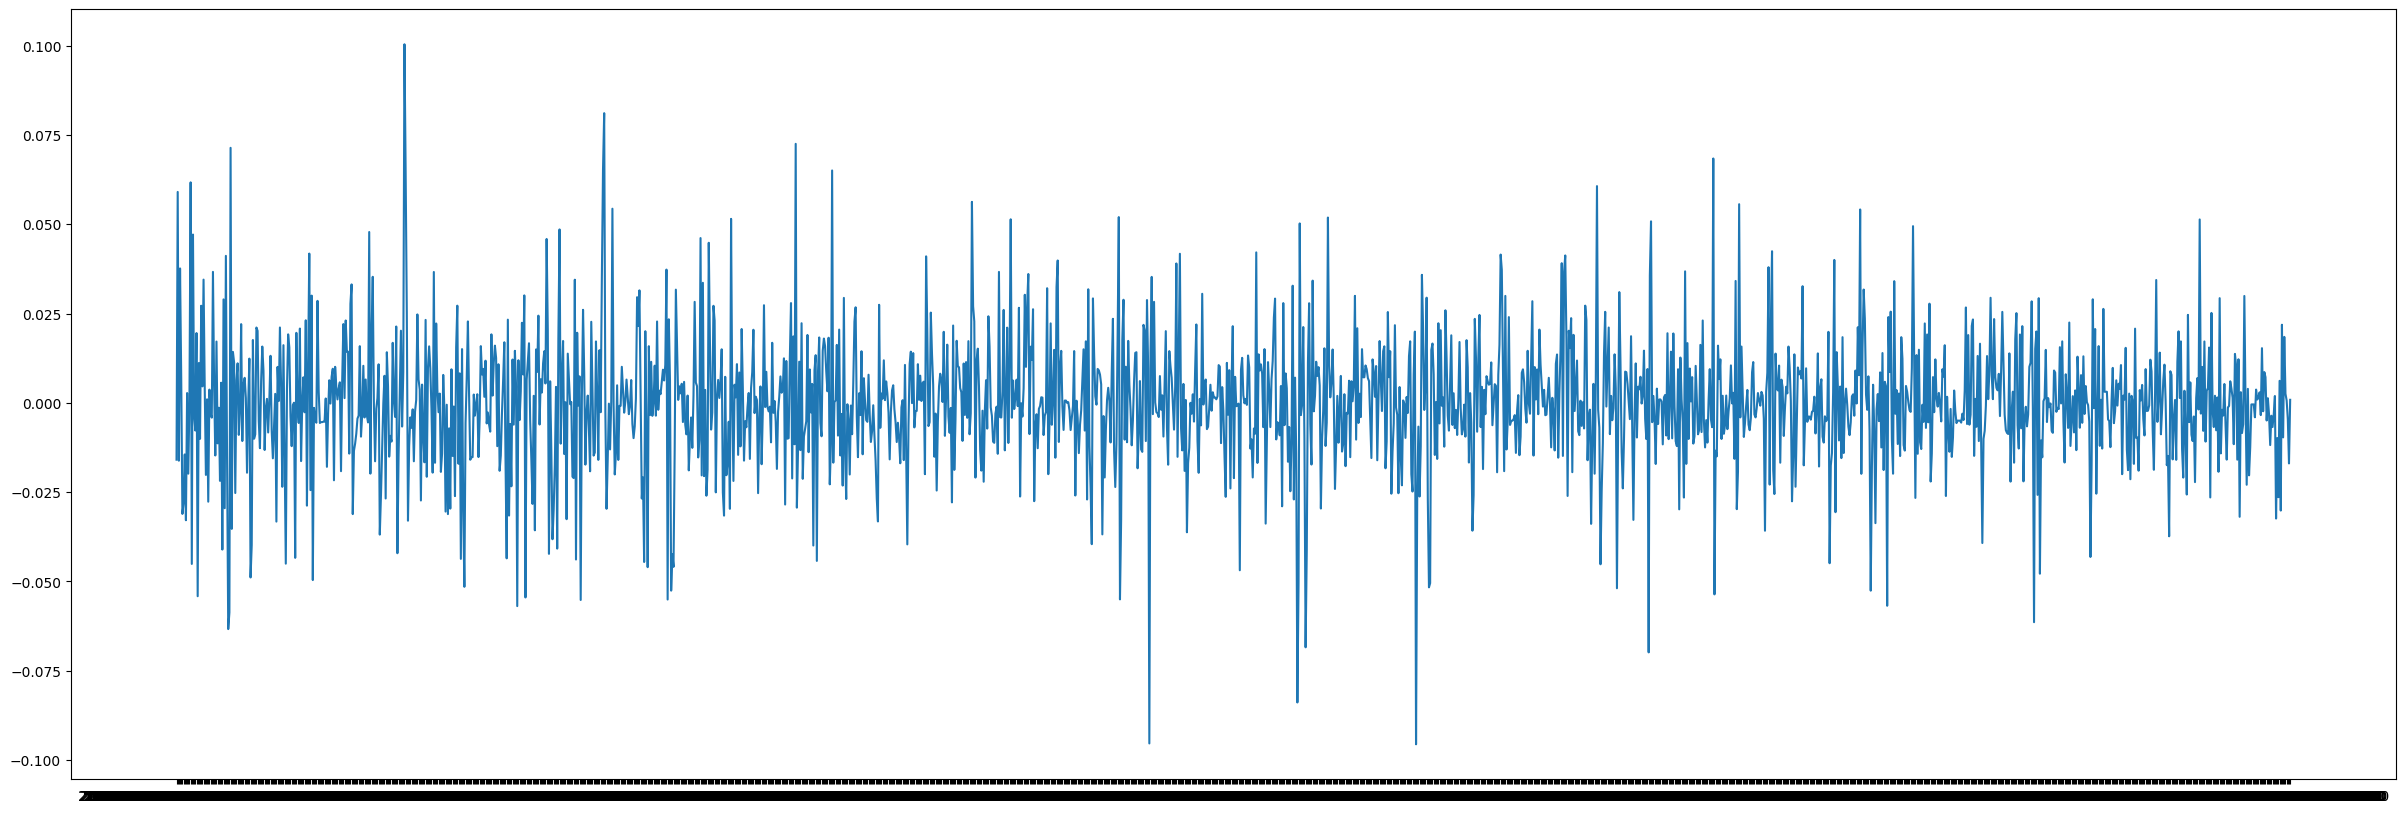

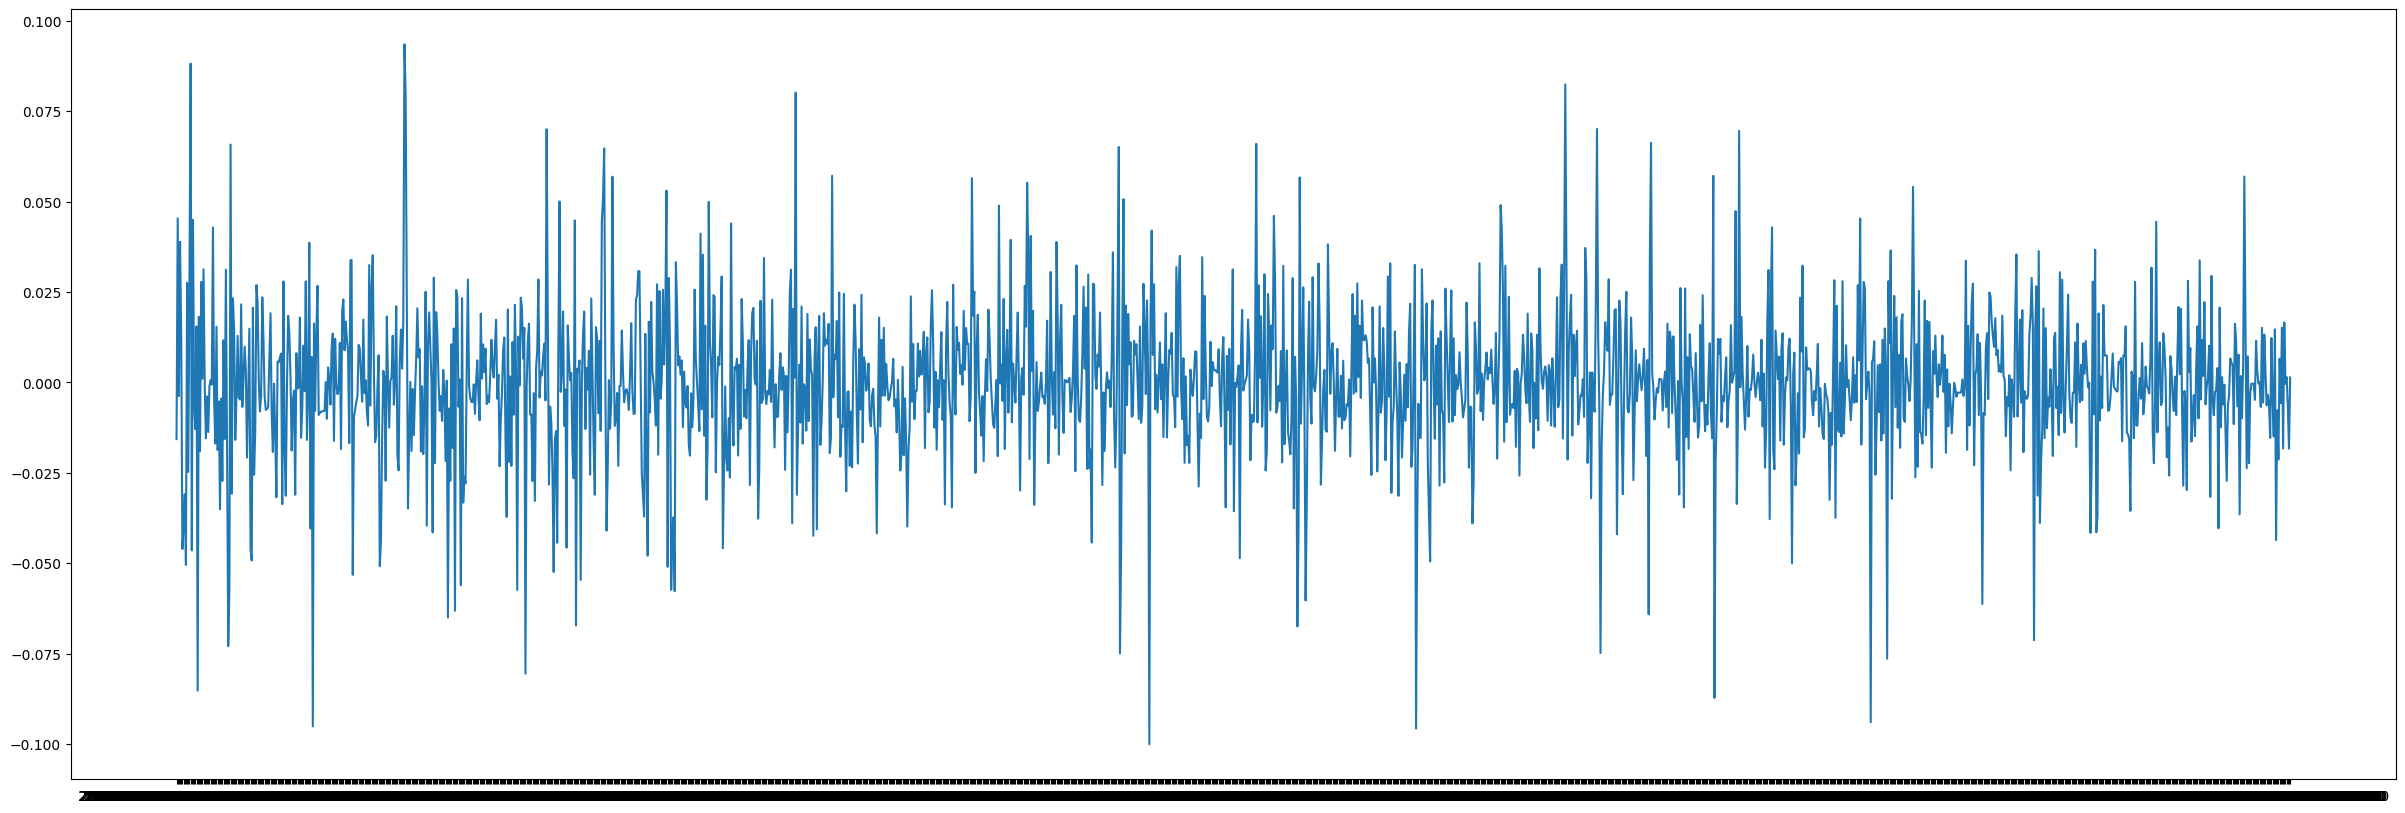

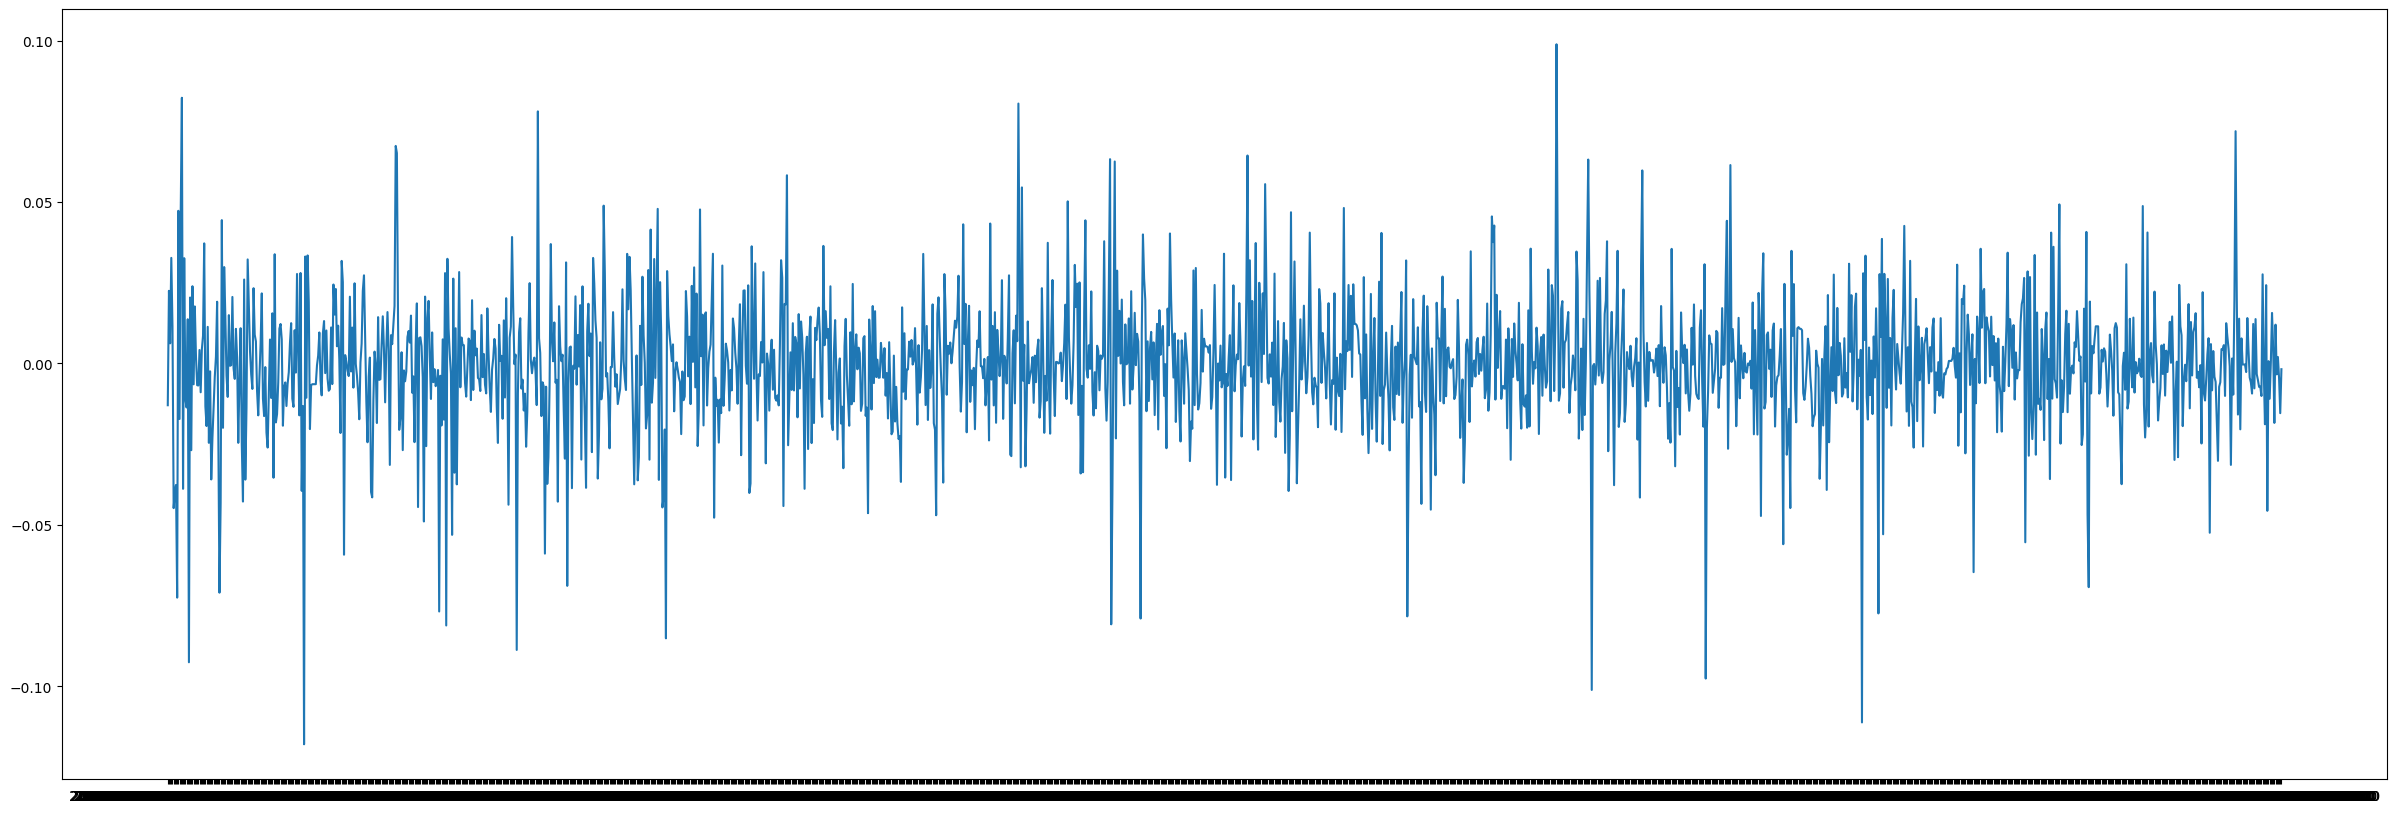

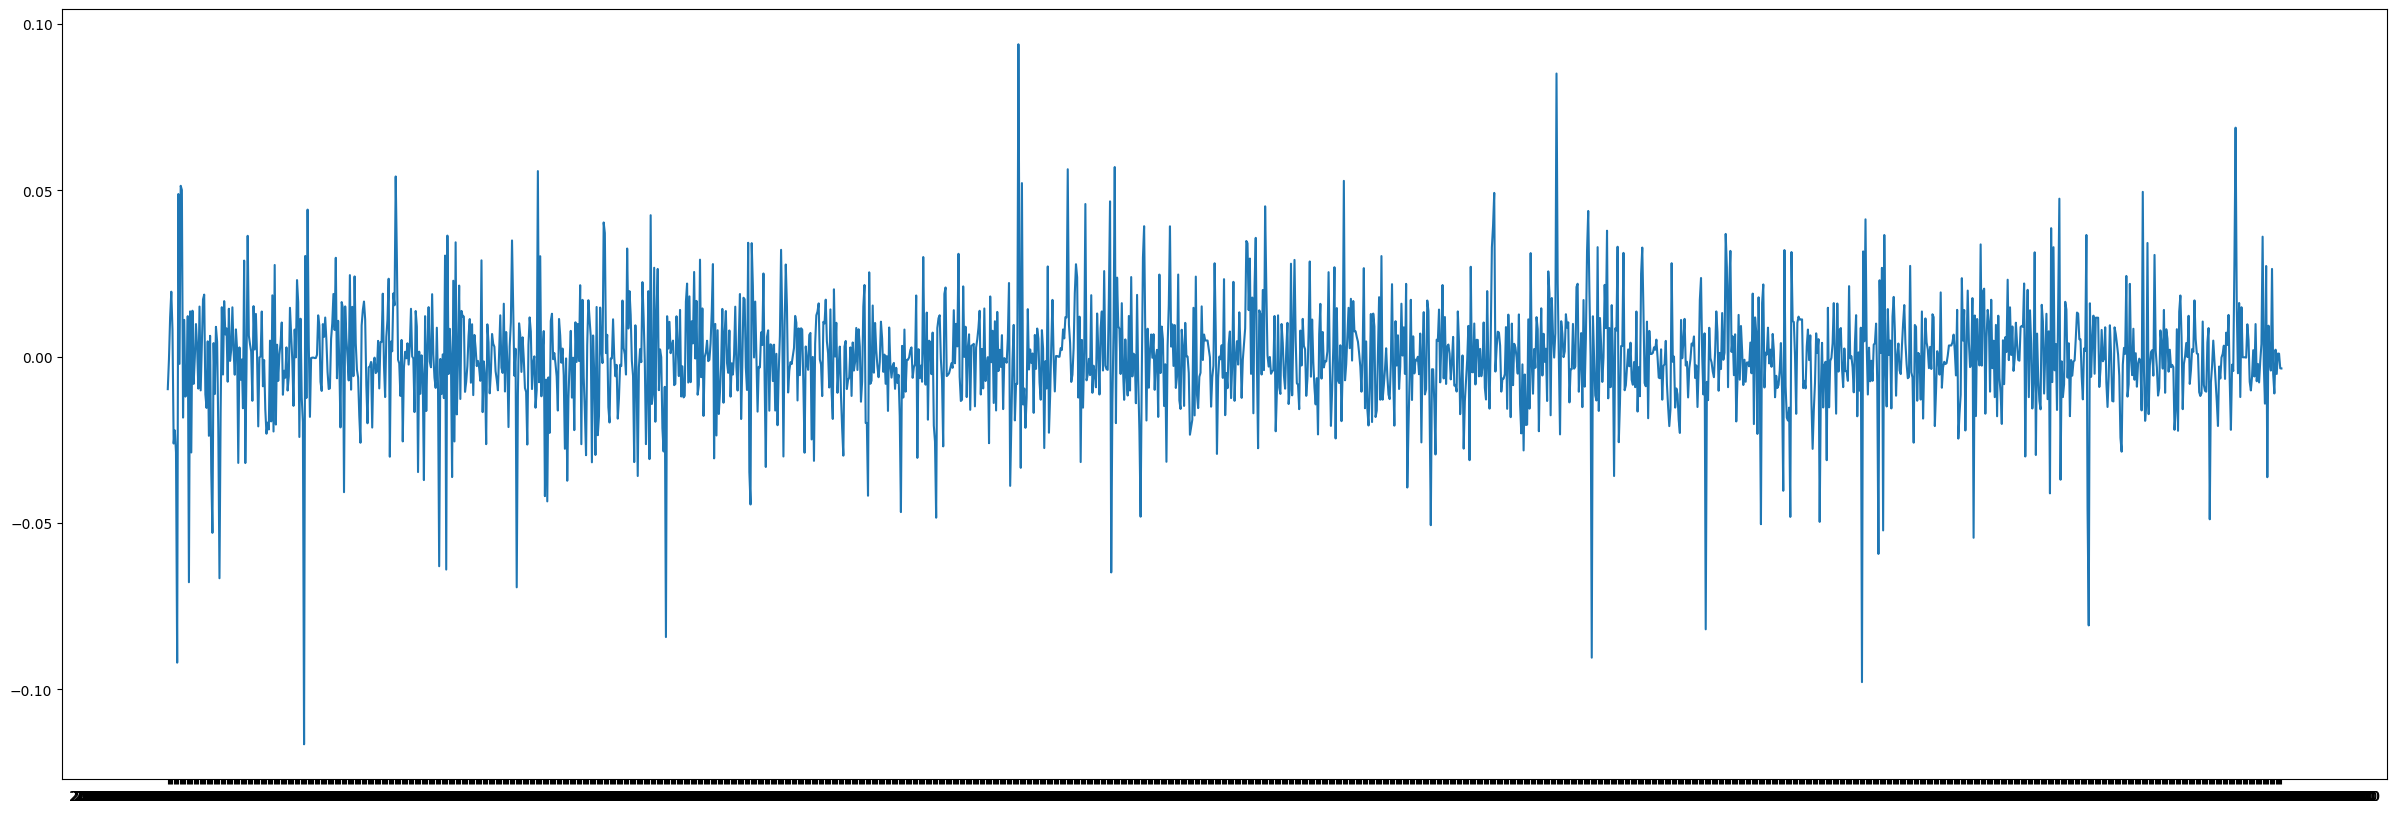

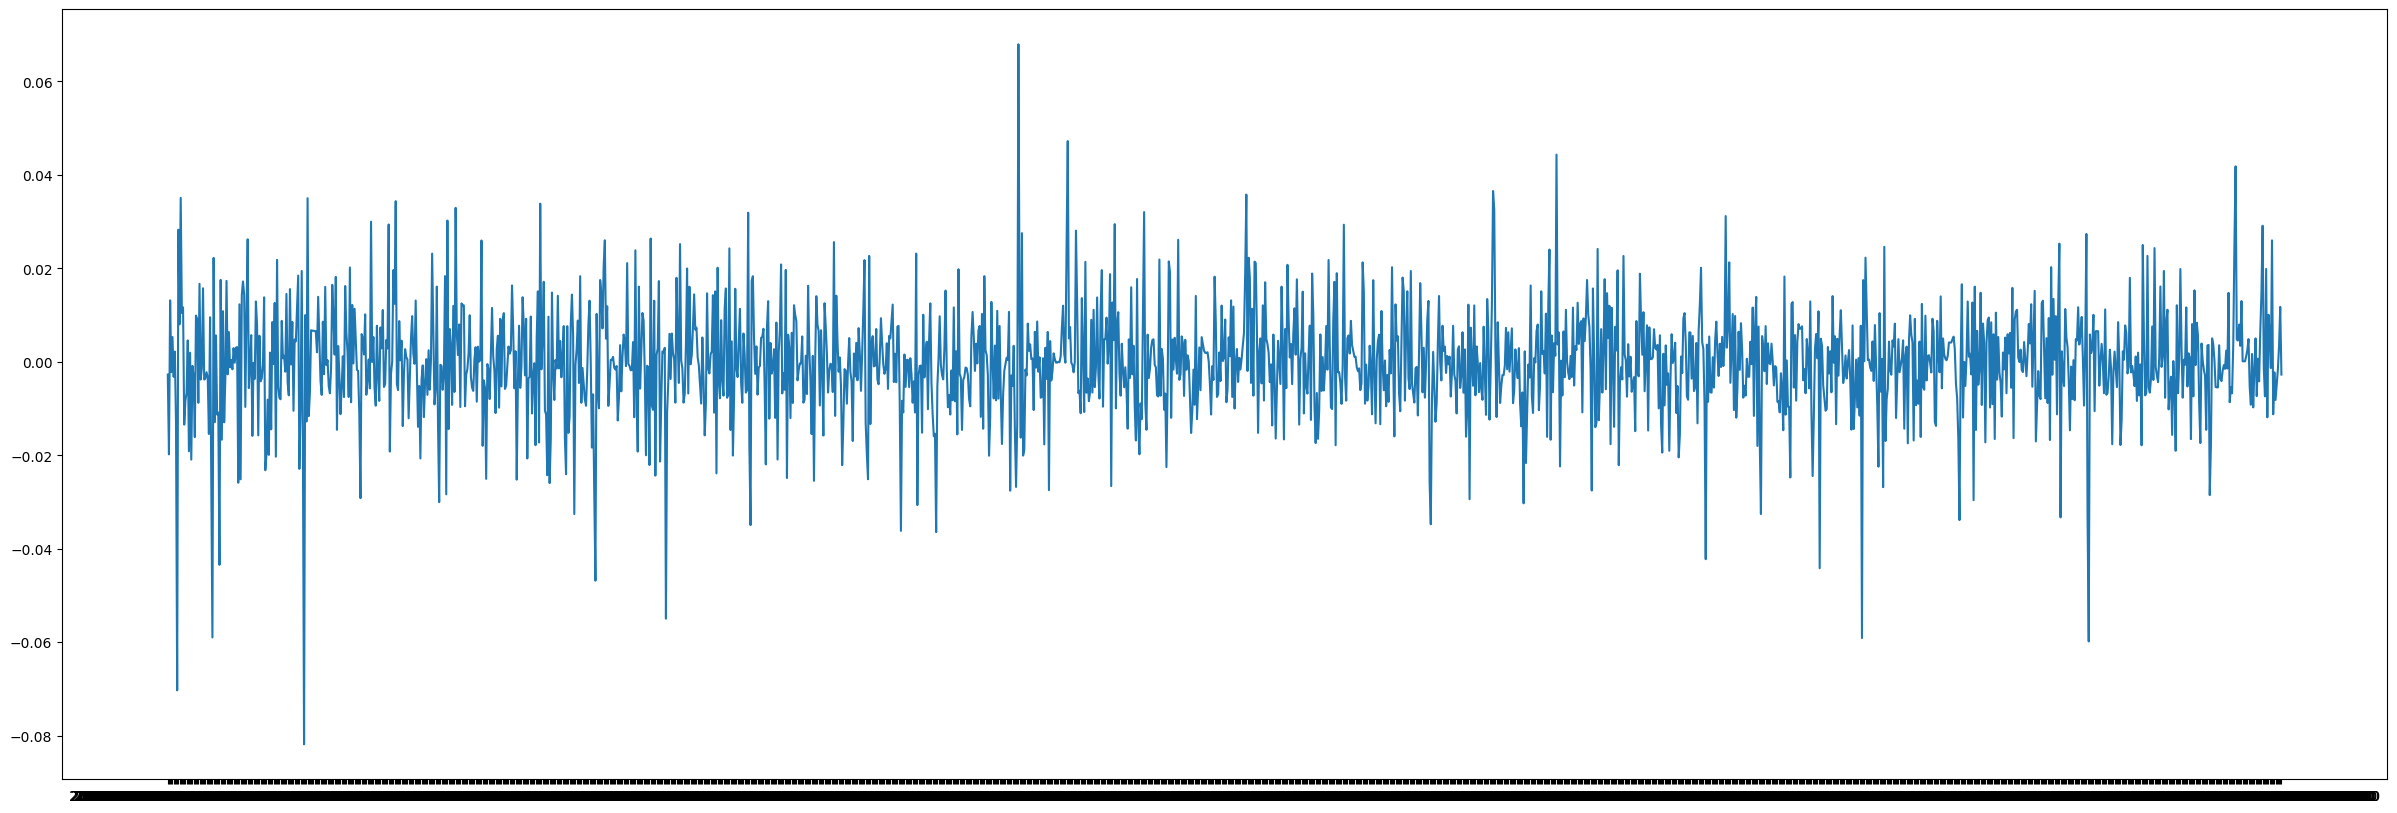

In [280]:
for column in train.columns:
    plt.figure(figsize=(30,10));
    plt.plot(train[column]);

In [317]:
# automatically estimate differencing term
from pmdarima.arima.utils import ndiffs
ndiffs(df['EUR'])

0

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


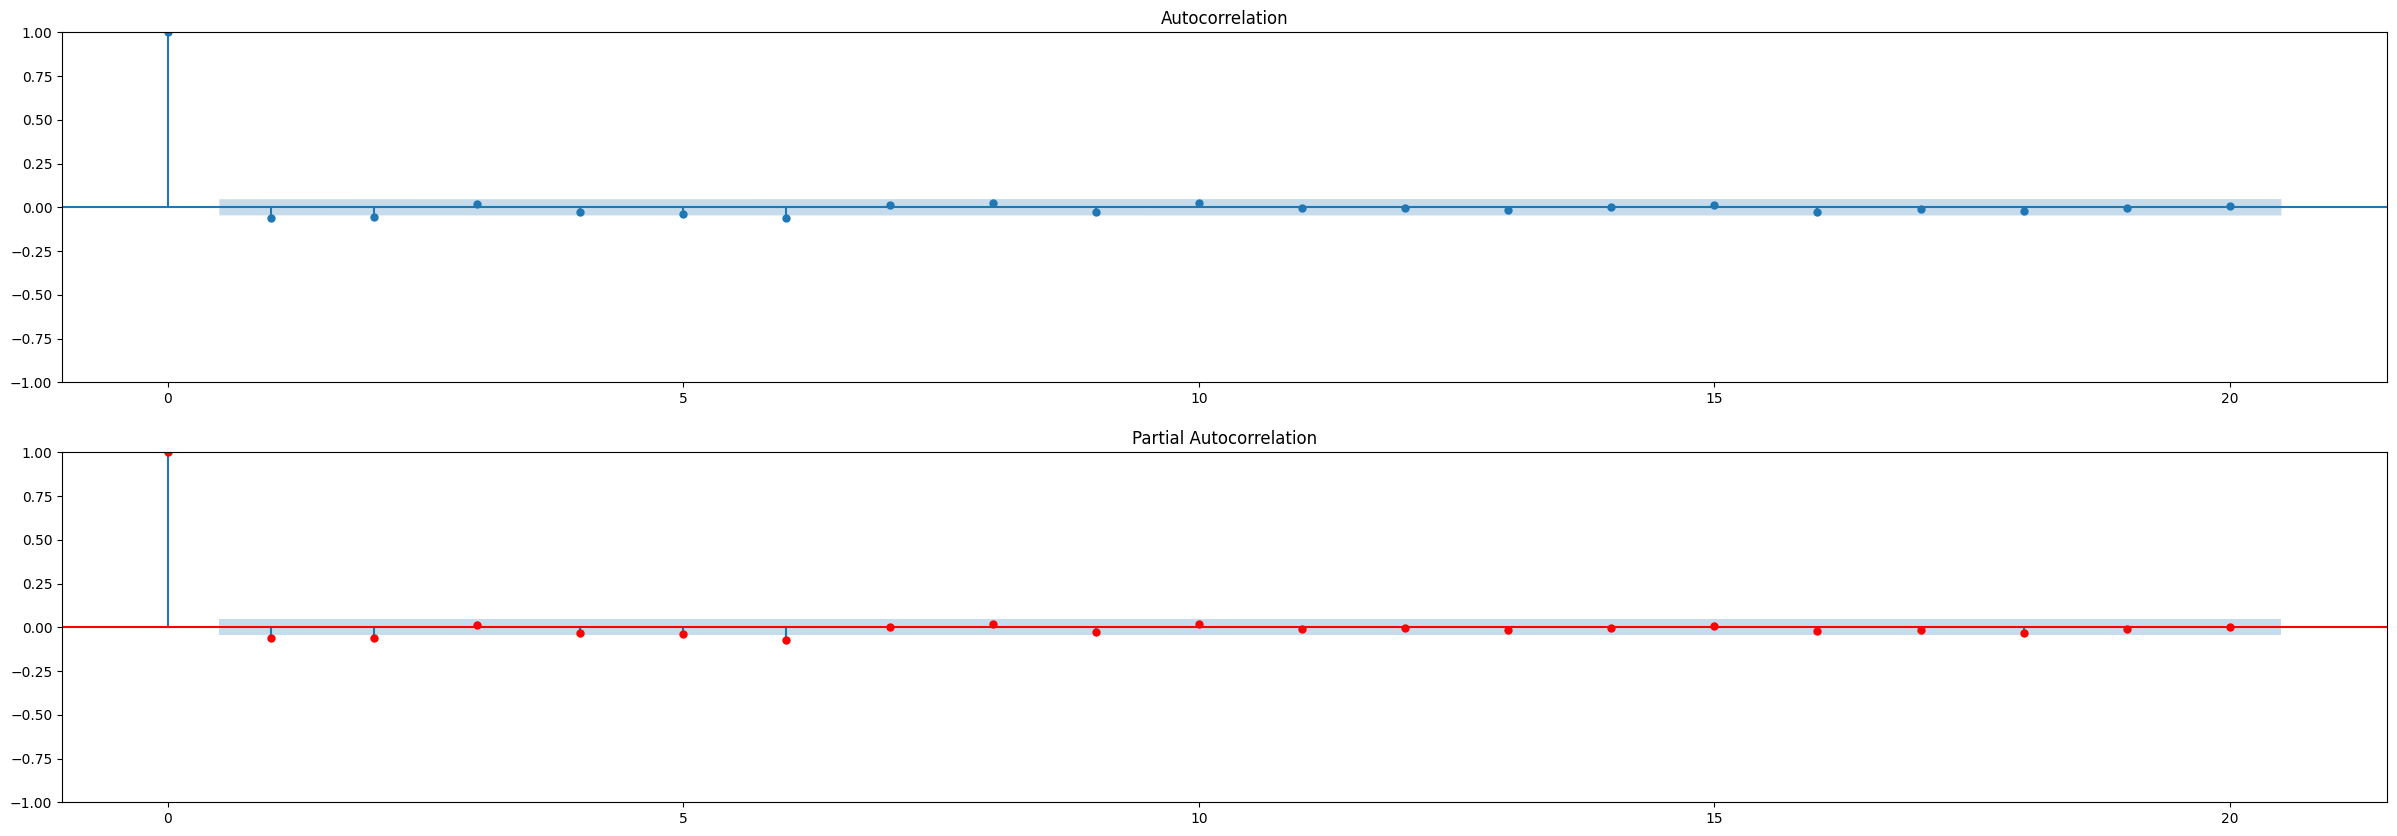

In [8]:
# ACF / PACF analysis of y_diff
fig, axes = plt.subplots(2,1, figsize=(30,10))
plot_acf(train.EUR, lags=20, ax=axes[0]);
plot_pacf(train.EUR, lags=20, ax=axes[1], c='r');

# 4. ARIMA with statsmodels

In [364]:
train.index

PeriodIndex(['2005-01-02 19:00', '2005-01-02 20:00', '2005-01-02 21:00',
             '2005-01-02 22:00', '2005-01-02 23:00', '2005-01-03 00:00',
             '2005-01-03 01:00', '2005-01-03 02:00', '2005-01-03 03:00',
             '2005-01-03 04:00',
             ...
             '2005-04-11 15:00', '2005-04-11 16:00', '2005-04-11 17:00',
             '2005-04-11 18:00', '2005-04-11 19:00', '2005-04-11 20:00',
             '2005-04-11 21:00', '2005-04-11 22:00', '2005-04-11 23:00',
             '2005-04-12 00:00'],
            dtype='period[H]', length=1800)

## a)  Find p & q for each currency

In [85]:
import warnings
from statsmodels.tsa.stattools import arma_order_select_ic

# parameters = {'AUD': [1,2],
#           'EUR': [1,2]...}

params = {}
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=Warning)
    for c in list(train.columns):
        res = arma_order_select_ic(train[c].values, max_ar=4, max_ma=2, ic='aic')
        # print(f'{c} mle retvals: {res.mle_retvals}')
        params[c] = (res.aic_min_order[0], 0, res.aic_min_order[1])
print(params)

{'AUD': (2, 0, 2), 'CAD': (3, 0, 0), 'CHF': (3, 0, 0), 'EUR': (0, 0, 2), 'GBP': (1, 0, 1), 'JPY': (1, 0, 1), 'NZD': (4, 0, 0), 'USD': (1, 0, 0)}


## b) Run ARIMA with the params above
Get dafaframes with predictions and confidence interval for all currencies

In [417]:
from statsmodels.tsa.arima.model import ARIMA
# forecast_index = forecast_results.predicted_mean.index
# forecast = forecast_results.predicted_mean

arima_forc_dict = {'next_hour_index': []}
conf_int_dict = {'next_hour_index': []}

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=Warning)
    
    for column in list(train.columns):

        arima = ARIMA(train[column],
                      order=params[column])
        arima_fit = arima.fit()
        forecast_results = arima_fit.get_forecast(5, alpha=0.05) # get_forecast( ) define the length of predictions
        
        arima_forc_dict['next_hour_index'] = list(forecast_results.predicted_mean.index) # hourly indexes we predict
        arima_forc_dict[column] = list(forecast_results.predicted_mean) # forecast values
        
        conf_int_dict['next_hour_index'] = list(forecast_results.conf_int().index)
        # conf_int_dict[column] = list(list(forecast_results.conf_int()))
        # print(f'{list(forecast_results.conf_int())} \n')
        lower = list(forecast_results.conf_int().iloc[:,0])
        upper = list(forecast_results.conf_int().iloc[:,1])
        
        conf_int_dict["next_hour_index"] = list(forecast_results.conf_int().index)
        conf_int_dict[list(forecast_results.conf_int())[0]] = lower
        conf_int_dict[list(forecast_results.conf_int())[1]] = upper
                       
# create df from the from dataframe with suitable lables and index
arima_pred_df = pd.DataFrame.from_dict(arima_forc_dict).set_index('next_hour_index')
conf_int = pd.DataFrame(conf_int_dict).set_index('next_hour_index')

In [387]:
arima_pred_df

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
next_hour_index,,,,,,,,
2005-03-18 19:00,0.000311,0.000712,0.000773,0.000937,0.000679,0.000550,-0.000269,-0.000024
2005-03-18 20:00,-0.000013,-0.000115,-0.000402,-0.000100,0.000438,0.000338,-0.000255,-0.000212
2005-03-18 21:00,-0.000101,-0.000272,-0.000152,-0.000119,0.000260,0.000177,-0.000039,-0.000199
2005-03-18 22:00,0.000075,0.000125,0.000083,-0.000119,0.000127,0.000054,-0.000225,-0.000200
2005-03-18 23:00,0.000046,0.000040,-0.000002,-0.000119,0.000028,-0.000039,-0.000363,-0.000200


In [389]:
conf_int

,lower AUD,upper AUD,lower CAD,upper CAD,lower CHF,upper CHF,lower EUR,upper EUR,lower GBP,upper GBP,lower JPY,upper JPY,lower NZD,upper NZD,lower USD,upper USD
next_hour_index,,,,,,,,,,,,,,,,
2005-03-18 19:00,-0.004690,0.005311,-0.016212,0.017636,-0.027942,0.029487,-0.034734,0.036607,-0.038548,0.039906,-0.038257,0.039357,-0.033129,0.032591,-0.022849,0.022801
2005-03-18 20:00,-0.005051,0.005024,-0.017134,0.016905,-0.029220,0.028416,-0.035837,0.035636,-0.038844,0.039721,-0.038522,0.039198,-0.033192,0.032682,-0.023091,0.022668
2005-03-18 21:00,-0.005139,0.004937,-0.017295,0.016751,-0.028994,0.028689,-0.035922,0.035683,-0.039054,0.039573,-0.038713,0.039067,-0.032977,0.032899,-0.023079,0.022681
2005-03-18 22:00,-0.004971,0.005120,-0.016932,0.017181,-0.028798,0.028964,-0.035922,0.035683,-0.039203,0.039457,-0.038853,0.038962,-0.033212,0.032761,-0.023079,0.022680
2005-03-18 23:00,-0.005001,0.005092,-0.017018,0.017097,-0.028884,0.028880,-0.035922,0.035683,-0.039311,0.039368,-0.038956,0.038879,-0.033374,0.032648,-0.023079,0.022680


In [391]:
# Test length to create DF
# print(f'{conf_int_dict.keys()} \n\n {conf_int_dict.values()} \n\n {len(conf_int_dict.keys())} \n\n {len(conf_int_dict.values())} ')

In [524]:
forecast = arima_pred_df.AUD
forecast.index = arima_pred_df.index.to_timestamp()
# forecast
conf = conf_int[['lower AUD', 'upper AUD']]
# conf.index = pd.to_datetime(conf_int.index)
# conf
# train.index = pd.to_datetime(train.index)
# test.index = pd.to_datetime(test.index)

# include train.index > '2015-04-12' # use this instaed of train
# conf_int.index = test.index
plt.figure(figsize=(15,5))
plt.plot(forecast, c='orange')
plt.plot(conf['lower AUD'], label='low', c='orange', ls='--')
plt.plot(conf['upper AUD'], label='high', c='orange', ls='--')
plt.plot(train, c='blue')
plt.plot(test, c='blue')
plt.fill_between(test.index, conf['lower AUD'], conf['upper AUD'], color='k', alpha=.15);
plt.legend()

AttributeError: 'Int64Index' object has no attribute 'to_timestamp'

# c) Plot confidence intervals for selected currency and step

In [522]:
y_test.index

DatetimeIndex(['2005-04-18 13:00:00', '2005-04-18 14:00:00',
               '2005-04-18 15:00:00', '2005-04-18 16:00:00',
               '2005-04-18 17:00:00'],
              dtype='datetime64[ns]', freq=None)

In [572]:
y_test

,AUD
2005-04-17 22:00:00+00:00,0.000021
2005-04-17 23:00:00+00:00,0.001792
2005-04-18 00:00:00+00:00,-0.009134
2005-04-18 01:00:00+00:00,-0.000419
2005-04-18 02:00:00+00:00,0.001962


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


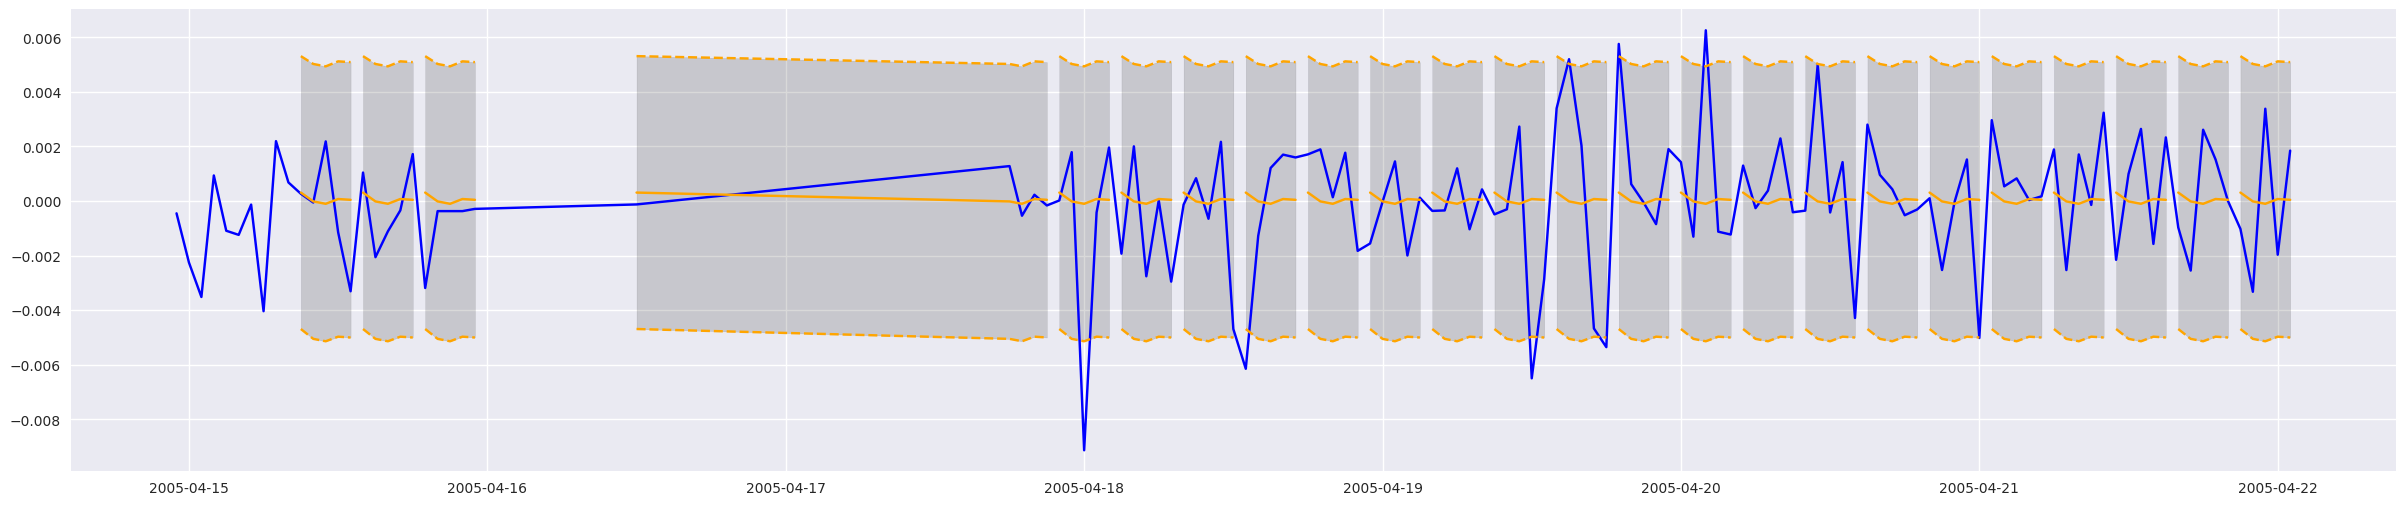

In [573]:
currency = 'AUD'

last = 130

# select columns with chosen currency
y_full = df[[x for x in df if x.endswith(currency)]]
# get only a subset
y = y_full[-last:]
y.index = pd.to_datetime(y.index).to_period('H').to_timestamp().values

# conf_int_viz = conf_int[[x for x in conf_int if x.endswith(currency)]]
# conf_int_viz.index = conf_int_viz.index.to_timestamp()

# y = arima_pred_df.reset_index()
step = 5 # have to be the same as the number forecasted hours, like len(arima_pred_df.index)

with plt.style.context("seaborn"):
    fig , ax = plt.subplots(nrows = 1 , ncols = 1, figsize=(30,6))
    ax.plot(y, c = "blue")
    # plt.xlim(date('2005-03-12'))
    
    for ind in range(10,130,step):     #int(0.9*len(df.index)), int(len(df.index)),step):      # range(30,100,step):
        
        y_train = y[:ind]
        y_test = y[ind:ind+step]
        
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', category=Warning)
            
            column=currency
            arima = ARIMA(train[column],order=params[column])
            arima_fit = arima.fit()
            forecast_results = arima_fit.get_forecast(step, alpha=0.05) # get_forecast( ) define the length of predictions
            
            forecast = forecast_results.predicted_mean.reset_index(drop=True)
            # forecast = arima.forecast(15, alpha=0.05)
            conf_int = pd.DataFrame(forecast_results.conf_int().values, columns=['low', 'high'])

            forecast.index = sorted(list(y_test.index))
            conf_int.index = sorted(list(y_test.index))
            ax.plot(forecast, c='orange')
            ax.plot(conf_int['low'], label='low', c='orange', ls='--')
            ax.plot(conf_int['high'], label='high', c='orange', ls='--')
    #         ax.plot(y_train, c='blue')
    #         ax.plot(y_test, c='blue')
            ax.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15);
                
        #         arima_forc_dict['next_hour_index'] = list(forecast_results.predicted_mean.index) # hourly indexes we predict
        #         arima_forc_dict[column] = list(forecast_results.predicted_mean) # forecast values
                
        #         conf_int_dict['next_hour_index'] = list(forecast_results.conf_int().index)
        #         # conf_int_dict[column] = list(list(forecast_results.conf_int()))
        #         # print(f'{list(forecast_results.conf_int())} \n')
        #         lower = list(forecast_results.conf_int().iloc[:,0])
        #         upper = list(forecast_results.conf_int().iloc[:,1])
        #         #labels
        #         conf_int_dict["next_hour_index"] = list(forecast_results.conf_int().index)
        #         conf_int_dict[list(forecast_results.conf_int())[0]] = lower
        #         conf_int_dict[list(forecast_results.conf_int())[1]] = upper
                
        # # create df from the from dataframe with suitable lables and index
        # arima_pred_df = pd.DataFrame.from_dict(arima_forc_dict).set_index('next_hour_index')
        # conf_int = pd.DataFrame(conf_int_dict).set_index('next_hour_index')[-last]
        # conf_int.index = conf_int.index.to_timestamp().values
    
        # ax.plot(arima_pred_df, c='orange')
        # ax.plot(conf_int['lower AUD'], label='low', c='orange', ls='--')
        # ax.plot(conf_int['upper AUD'], label='high', c='orange', ls='--')
        # ax.fill_between(y_test.index, conf_int['low'], conf_int['high'], color='k', alpha=.15);

In [559]:
limit = -len(y[:ind])
y_full[:limit]

,AUD
2005-01-02 19:00:00+00:00,0.000637
2005-01-02 20:00:00+00:00,-0.001499
2005-01-02 21:00:00+00:00,-0.003176
2005-01-02 22:00:00+00:00,0.004870
2005-01-02 23:00:00+00:00,0.000599
...,...
2005-04-14 23:00:00+00:00,-0.000450
2005-04-15 00:00:00+00:00,-0.002254
2005-04-15 01:00:00+00:00,-0.003516
2005-04-15 02:00:00+00:00,0.000938


In [509]:
test.head()

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
2005-04-12 01:00:00,0.000307,-0.000286,-0.001296,0.001158,0.006833,0.010848,0.010555,0.006721
2005-04-12 02:00:00,0.000802,0.003055,0.003685,-0.000384,-0.006163,-0.009124,-0.007061,-0.001784
2005-04-12 03:00:00,-0.001721,-0.003975,-0.002853,-0.000241,0.001151,0.001054,-0.001331,-0.003472
2005-04-12 04:00:00,0.000337,0.000196,-0.001368,-0.002504,-0.001956,-0.001543,-0.001202,0.000507
2005-04-12 05:00:00,0.000893,0.002946,0.003517,0.000911,-0.003058,-0.006339,-0.007316,-0.005009


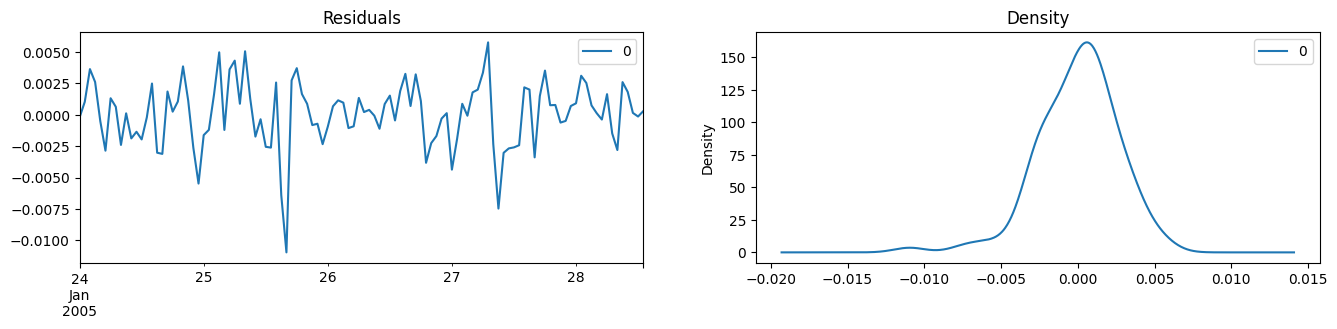

In [248]:
residuals = pd.DataFrame(arima_fit.resid)

fig, ax = plt.subplots(1,2, figsize=(16,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1]);

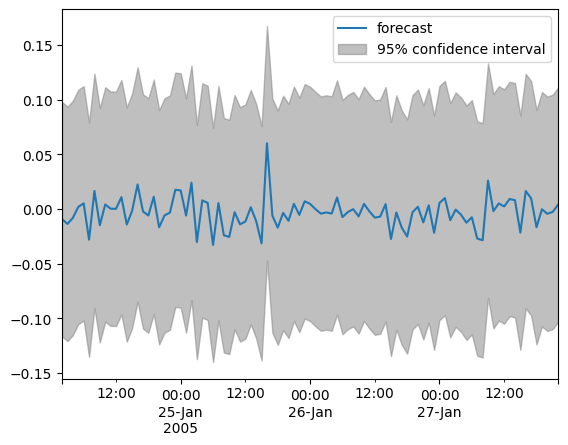

In [197]:
plot_predict(arima_fit, start=1, dynamic=False);
plt.xlim()

<AxesSubplot:>

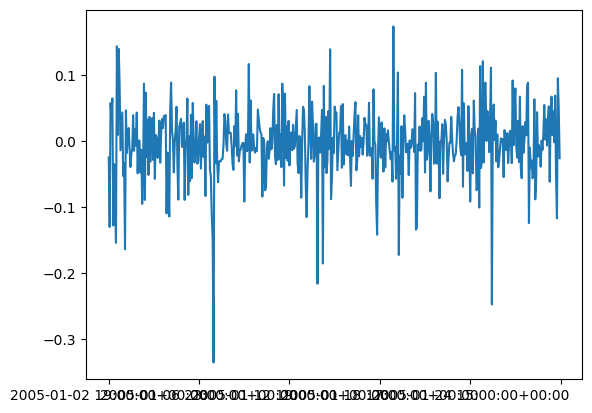

In [168]:
# df.EUR.plot(index=df.index.to_timestamp())

# 5. ARIMA with pmdarima package

In [143]:
model = pm.auto_arima(train.EUR,
                      start_p=1, max_p=3,
                      start_q=1, max_q=3,
                      seasonal=False,
                      suppress_warnings=True,
                      trace=True)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1505.431, Time=0.30 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-1504.018, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1507.204, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-1506.947, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-1505.472, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1503.477, Time=0.30 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=-1508.988, Time=0.11 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=-1505.098, Time=0.09 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=-1507.118, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1507.093, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-1508.776, Time=0.15 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-1505.768, Time=0.52 sec

Best model:  ARIMA(1,0,0)(0,0,0)[0] intercept
Total fit time: 2.098 seconds


In [144]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  500
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 757.494
Date:                Wed, 31 Aug 2022   AIC                          -1508.988
Time:                        15:10:16   BIC                          -1496.344
Sample:                             0   HQIC                         -1504.027
                                - 500                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0047      0.003     -1.802      0.071      -0.010       0.000
ar.L1         -0.1083      0.033     -3.293      0.001      -0.173      -0.044
sigma2         0.0028      0.000     26.324      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               571.78
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.79   Skew:                            -0.97
Prob(H) (two-sided):                  0.13   Kurtosis:                         7.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [146]:
type(model.arima_res_.resid)
type(model.predict(n_periods=1))

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


pandas.core.series.Series

# 6. Statsmodels ARIMA + Garch

In [590]:
from termcolor import colored

arima_forc_dict = {'next_hour_index': []}

with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=Warning)
    vol_dict = {'next_hour_index': []}
    for column in list(train.columns):

        arima = ARIMA(train[column], order=params[column])
        arima_fit = arima.fit()
        forecast_results = arima_fit.get_forecast(1, alpha=0.05) # get_forecast( ) define the length of predictions
        
        arima_forc_dict['next_hour_index'] = list(forecast_results.predicted_mean.index) # hourly indexes we predict
        arima_forc_dict[column] = list(forecast_results.predicted_mean) # forecast values
        
        # conf_int_dict['next_hour_index'] = list(forecast_results.conf_int().index)
        # # conf_int_dict[column] = list(list(forecast_results.conf_int()))
        # # print(f'{list(forecast_results.conf_int())} \n')
        # lower = list(forecast_results.conf_int().iloc[:,0])
        # upper = list(forecast_results.conf_int().iloc[:,1])
        
        # conf_int_dict["next_hour_index"] = list(forecast_results.conf_int().index)
        # conf_int_dict[list(forecast_results.conf_int())[0]] = lower
        # conf_int_dict[list(forecast_results.conf_int())[1]] = upper
    
        # Use residuals in the Garch    
        garch = arch.arch_model(arima_forc_dict[column], p=1, q=1)
        garch_fitted = garch.fit()
        # Use GARCH to predict the residual
        garch_forecast = garch_fitted.forecast(horizon=1,reindex=False)
        predicted_et = garch_forecast.mean['h.1'].iloc[-1]
    
        # Combine both models' output: yt = mu + et
        volatility = arima_forc_dict[column] + predicted_et
        # Put them into dict
        vol_dict['next_hour_index'] = list(forecast_results.predicted_mean.index)
        vol_dict[column] = volatility
        print(colored(f'\n \n Predicted volatility for {column} currency is: {volatility}','red'))   
    
    vol_df = pd.DataFrame.from_dict(vol_dict).set_index('next_hour_index')

Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for AUD currency is: [0.00062148]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for CAD currency is: [0.00142355]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for CHF currency is: [0.00154548]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for EUR currency is: [0.00187327]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for GBP currency is: [0.0013581]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for JPY currency is: [0.00110062]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for NZD currency is: [-0.00053779]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


Iteration:      1,   Func. Count:      4,   Neg. LLF: nan
Inequality constraints incompatible    (Exit mode 4)
            Current function value: nan
            Iterations: 1
            Function evaluations: 4
            Gradient evaluations: 1

 
 Predicted volatility for USD currency is: [-4.77516442e-05]


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:753: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


In [597]:
forecast_results.conf_int()

,lower USD,upper USD
1800,-0.022849,0.022801


In [599]:
vol_df

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
next_hour_index,,,,,,,,
1800,0.000621,0.001424,0.001545,0.001873,0.001358,0.001101,-0.000538,-0.000048


In [608]:
df.iloc[1800]

AUD    0.000307
CAD   -0.000286
CHF   -0.001296
EUR    0.001158
GBP    0.006833
JPY    0.010848
NZD    0.010555
USD    0.006721
Name: 2005-04-12 01:00:00+00:00, dtype: float64

In [609]:
vol_df*1000 - df.iloc[1800]*1000

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
next_hour_index,,,,,,,,
1800,0.314375,1.709934,2.841505,0.715397,-5.475175,-9.747736,-11.092991,-6.769032


In [ ]:
# residuals are saved in dateframe already arima_pred_df
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_pred_df, p=1, q=1)
garch_fitted = garch.fit()
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1,
                                    #    method='simulation', # use if horizon > 1
                                       reindex=False)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
volatility = list(arima_pred_df.column) + predicted_et
print(f'\n \n Predicted value: is \n {volatility}')

In [544]:
arima_pred_df

,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
next_hour_index,,,,,,,,
1800,0.000311,0.000712,0.000773,0.000937,0.000679,0.000550,-0.000269,-0.000024
1801,-0.000013,-0.000115,-0.000402,-0.000100,0.000438,0.000338,-0.000255,-0.000212
1802,-0.000101,-0.000272,-0.000152,-0.000119,0.000260,0.000177,-0.000039,-0.000199
1803,0.000075,0.000125,0.000083,-0.000119,0.000127,0.000054,-0.000225,-0.000200
1804,0.000046,0.000040,-0.000002,-0.000119,0.000028,-0.000039,-0.000363,-0.000200


In [111]:
# best params
print(model.order)
print('---===---')
arima_residuals = model.arima_res_.resid
# Use ARIMA to predict mu
predicted_mu = model.predict(n_periods=1)
predicted_mu
# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals,
                        # vol=EGARCH
                        p=1,
                        # o=0
                        q=1)
garch_fitted = garch.fit()
# Use GARCH to predict the residual
garch_forecast = garch_fitted.forecast(horizon=1,
                                    #    method='simulation', # use if horizon > 1
                                       reindex=False)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
volatility = predicted_mu + predicted_et
print(f'\n \n Predicted value: is \n {volatility}')

(1, 0, 0)
---===---
Iteration:      1,   Func. Count:      6,   Neg. LLF: 7900662.370997072
Iteration:      2,   Func. Count:     17,   Neg. LLF: 250508.78664482673
Iteration:      3,   Func. Count:     23,   Neg. LLF: -773.3455238884584
Iteration:      4,   Func. Count:     30,   Neg. LLF: -755.9930168253004
Iteration:      5,   Func. Count:     36,   Neg. LLF: -787.3271156857519
Iteration:      6,   Func. Count:     42,   Neg. LLF: -788.5821252269459
Iteration:      7,   Func. Count:     48,   Neg. LLF: -786.7534831440187
Iteration:      8,   Func. Count:     55,   Neg. LLF: -787.2687234433236
Iteration:      9,   Func. Count:     61,   Neg. LLF: -789.4030071854964
Iteration:     10,   Func. Count:     66,   Neg. LLF: -789.4033595887508
Iteration:     11,   Func. Count:     71,   Neg. LLF: -789.4033616258314
Iteration:     12,   Func. Count:     75,   Neg. LLF: -789.4033616258412
Optimization terminated successfully    (Exit mode 0)
            Current function value: -789.4033616258

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.002829. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [112]:
print(garch_forecast.mean['h.1'].iloc[-1])

0.0024409345241092457


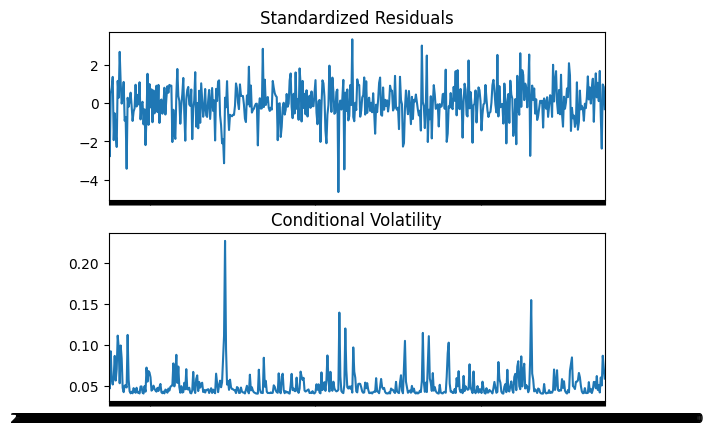

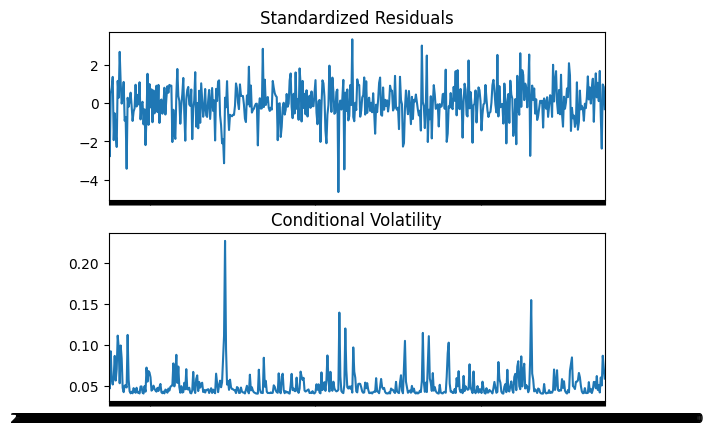

In [113]:
garch_fitted.plot()

In [105]:
garch_fitted.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                789.403
Distribution:                  Normal   AIC:                          -1570.81
Method:            Maximum Likelihood   BIC:                          -1553.95
                                        No. Observations:                  500
Date:                Wed, Aug 31 2022   Df Residuals:                      499
Time:                        12:01:02   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.4409e-03  2.296e-03      1.063      0.288 [-2.058e-03,6.940e-03]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.4622e-03  4.538e-04      3.222  1.274e-03 [5.726e-04,2.352e-03]
alpha[1]       0.3998      0.118      3.378  7.311e-04     [  0.168,  0.632]
beta[1]        0.1158      0.168      0.690      0.490     [ -0.213,  0.445]
============================================================================

Covariance estimator: robust
"""

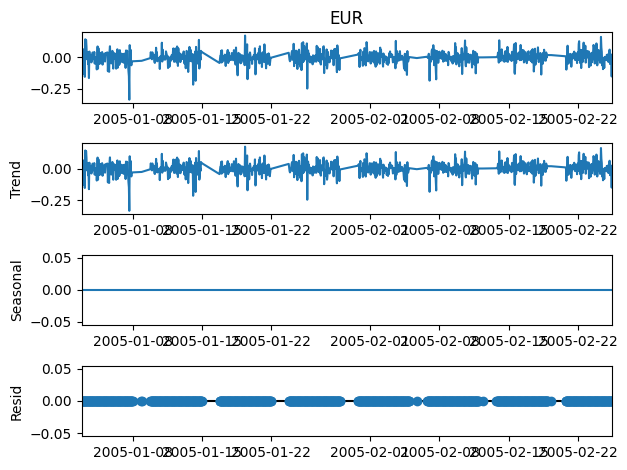

In [98]:
result_add = seasonal_decompose(data.EUR[:1000], period=1, model='additive')
result_add.plot();
# result_mul = seasonal_decompose(df['EUR'], model='multiplicative')

In [19]:
%%time

def getSeasonality(data, rows=10, period=1):
    '''
    Check seasonality of the given data
    '''
    %%time
    for column in data.columns:
        result_add = seasonal_decompose(data[column][-rows], period = period, model='additive', extrapolate_trend='freq')
        result_mul = seasonal_decompose(data[column][-rows], period = period, model='multiplicative', extrapolate_trend='None')
        f, (ax1, ax2) = plt.subplots(1,2, figsize=(13,6))
        ax1.plot(result_add.resid); ax1.set_title("Additive Model Residuals")
        ax2.plot(result_mul.resid); ax2.set_title("Multiplicative Model Residuals")
        plots = []
        plots.append(plt.show())
    return plots

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.87 µs


In [ ]:
model.arima_res_.resid

In [ ]:
from scipy.signal import butter,lfilt

# Filter requirements.
T = 5.0         # Sample Period
fs = 30.0       # sample rate, Hz
cutoff = 2      # desired cutoff frequency of the filter, Hz ,      slightly higher than actual 1.2 Hz
nyq = 0.5 * fs  # Nyquist Frequency
order = 2       # sin wave can be approx represented as quadratic
n = int(T * fs) # total number of samples

def butter_lowpass_filter(d, cutoff=2, fs=30, order):
    
    
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = lfilt(b, a, data)
    return y

# Volatility with filtered ARIMA + GARCH

In [129]:
def getVolatility(d):
    '''
    Get volatility prediction pd.Series for the all data.columns
    '''
    # %%time
    
    vol_dict = {}
    for column in d.columns:
        
        model = pm.auto_arima(d[column],
                            start_p=0, max_p=3,
                            start_q=0, max_q=3,
                            seasonal=False,
                            suppress_warnings=True,
                            trace=True)
        
        arima_residuals = model.arima_res_.resid
        # Use ARIMA to predict mu for just next hour n_periods=1
        predicted_mu = model.predict(n_periods=1)

        # fit a GARCH(1,1) model on the residuals of the ARIMA model
        garch = arch.arch_model(arima_residuals,
                                  p=1,
                                  q=1)
        garch_fitted = garch.fit()

        # Use GARCH to predict the residual
        garch_forecast = garch_fitted.forecast(horizon=1,
                                                   reindex=True)
        predicted_et = garch_forecast.mean['h.1'].iloc[-1]

        # Combine both models' output: yt = mu + et
        volatility = predicted_mu + predicted_et
        print(f'\n Predicted value: is \n {volatility}')
        vol_dict[column] = volatility
    # vol_df = pd.DataFrame.from_dict(vol_dict)
    img plt.show()
    return img

In [132]:
dataframe = pd.read_csv(os.path.join(wpath, os.path.basename(TERTIARY_PATH), 'logs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')* 10
dataframe = dataframe[:1000]

In [134]:
# start_p and start_q from 0
getVolatility(dataframe)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2391.648, Time=0.45 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2403.152, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2390.667, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2389.777, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2391.532, Time=0.09 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2391.894, Time=0.26 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2391.185, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.073 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3132.550568748983
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2708236.579912933
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1284.9695563380697
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1187.4106041151854
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1187.386837476992
Iteration:      6,   Func. Count:     38,   Neg. LLF: 11

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2725.826, Time=0.18 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2733.529, Time=0.18 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2730.478, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2729.424, Time=0.10 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2726.260, Time=0.22 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2725.818, Time=0.90 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2723.823, Time=0.07 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2725.820, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2727.743, Time=1.34 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2725.053, Time=0.13 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 3.266 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5049.987458207479
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4743.948861173891
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1411.4731530006409
Iteration:      4,   Func. Count:     29,   Ne

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.52 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2773.263, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2501.279, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2771.267, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2392.502, Time=0.14 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2340.018, Time=0.23 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.26 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2338.023, Time=0.51 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2390.505, Time=0.11 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=1.16 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=1.22 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 14.415 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4806.3285166624555
Iteration:      2,   

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2180.489, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1872.887, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.57 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2178.489, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1755.091, Time=0.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1688.579, Time=1.32 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.43 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.56 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1686.579, Time=0.10 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1753.091, Time=0.12 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.91 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.87 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 8.451 seconds


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Iteration:      1,   Func. Count:      6,   Neg. LLF: 2874.713418412088
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2219.839501936523
Iteration:      3,   Func. Count:     24,   Neg. LLF: 935.5918713936485
Iteration:      4,   Func. Count:     31,   Neg. LLF: 814.2152269198014
Iteration:      5,   Func. Count:     37,   Neg. LLF: 803.6746870251006
Iteration:      6,   Func. Count:     42,   Neg. LLF: 803.6744165714258
Iteration:      7,   Func. Count:     47,   Neg. LLF: 803.6744138295418
Iteration:      8,   Func. Count:     51,   Neg. LLF: 803.6744138293775
Optimization terminated successfully    (Exit mode 0)
            Current function value: 803.6744138295418
            Iterations: 8
            Function evaluations: 51
            Gradient evaluations: 8

 Predicted value: is 
 1000   -0.366715
dtype: float64
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1826.144, Time=0.66 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1832.952, 

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2467.102, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2467.886, Time=0.06 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2467.693, Time=0.09 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2468.887, Time=0.28 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.588 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11204.18207984942


/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Iteration:      2,   Func. Count:     14,   Neg. LLF: 3783.560632701916
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1237.7108849697433
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1203.9999929806
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1204.01450964397
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1203.955722898034
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1203.953890187483
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1203.9538902256595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1203.953890187483
            Iterations: 8
            Function evaluations: 49
            Gradient evaluations: 8

 Predicted value: is 
 1000   -0.005404
dtype: float64
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2598.809, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2630.794, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2612.295, Time=0.

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2667.712, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2668.080, Time=0.08 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2666.593, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2666.453, Time=0.05 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2668.074, Time=0.07 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2669.707, Time=0.28 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2668.377, Time=0.12 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 0.809 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3757.198600640907
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157229.18291829474
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1320.2034396642694
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1303.0791090056846
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1280.2533590410749
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1270.7298121691217
Iteration:      7,   Fun

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
1000,0.091608,-0.17814,-0.469379,-0.366715,-0.11898,-0.005404,0.030651,0.045216


In [139]:
# start_p and start_q from 1
getVolatility(dataframe)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2391.648, Time=1.00 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2403.152, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2390.667, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2389.777, Time=0.08 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2391.532, Time=0.21 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2391.894, Time=0.32 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2391.185, Time=0.21 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.936 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3132.550568748983
Iteration:      2,   Func. Count:     14,   Neg. LLF: 2708236.579912933
Iteration:      3,   Func. Count:     21,   Neg. LLF: 1284.9695563380697
Iteration:      4,   Func. Count:     28,   Neg. LLF: 1187.4106041151854
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1187.386837476992
Iteration:      6,   Func. Count:     38,   Neg. LLF: 11

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2725.826, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2733.529, Time=0.15 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2730.478, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2729.424, Time=0.13 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2726.260, Time=0.20 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2725.818, Time=0.61 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2723.823, Time=0.37 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2725.820, Time=0.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2727.743, Time=1.34 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=2725.053, Time=0.87 sec

Best model:  ARIMA(0,0,2)(0,0,0)[0]          
Total fit time: 4.532 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 5049.987458207479
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4743.948861173891
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1411.4731530006409
Iteration:      4,   Func. Count:     29,   Ne

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.06 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2773.263, Time=0.44 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2501.279, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.92 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2771.267, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2392.502, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2340.018, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=3.29 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=2338.023, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=2390.505, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=1.33 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.69 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 13.508 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 4806.3285166624555
Iteration:      2,   

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.11 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2180.489, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1872.887, Time=0.24 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2178.489, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1755.091, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1688.579, Time=0.45 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.63 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=2.01 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=1686.579, Time=0.12 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=1753.091, Time=0.08 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=0.43 sec

Best model:  ARIMA(3,1,0)(0,0,0)[0]          
Total fit time: 7.532 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 2874.713418412088
Iteration:      2,   Fu

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1826.144, Time=0.15 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1832.952, Time=0.22 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=1830.907, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=1830.348, Time=0.51 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1825.899, Time=0.20 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=1828.889, Time=0.17 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1827.853, Time=0.48 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1825.393, Time=0.41 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1825.675, Time=0.23 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1825.445, Time=0.63 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=1825.699, Time=0.62 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=1827.550, Time=0.41 sec
 ARIMA(3,0,3)(0,0,0)[0]             : AIC=1826.592, Time=0.91 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=1826.762, Time=0.95 sec

Best model:  ARIMA(2,0,2)(0,0,0)[0]          
Total fit time: 6.059 seconds

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2467.886, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2467.693, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=2468.887, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 0.752 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 11204.18207984942
Iteration:      2,   Func. Count:     14,   Neg. LLF: 3783.560632701916
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1237.7108849697433
Iteration:      4,   Func. Count:     29,   Neg. LLF: 1203.9999929806
Iteration:      5,   Func. Count:     34,   Neg. LLF: 1204.01450964397
Iteration:      6,   Func. Count:     40,   Neg. LLF: 1203.955722898034
Iteration:      7,   Func. Count:     45,   Neg. LLF: 1203.953890187483
Iteration:      8,   Func. Count:     49,   Neg. LLF: 1203.9538902256595
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1203.953890187483
            Iterations: 8
            Func

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2598.809, Time=0.35 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2630.794, Time=0.07 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2612.295, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2608.905, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2600.750, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2600.767, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2604.413, Time=0.21 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=2610.597, Time=0.06 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2602.060, Time=0.43 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=2599.288, Time=0.45 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0]          
Total fit time: 2.142 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 6363464284.628277
Iteration:      2,   Func. Count:     14,   Neg. LLF: 4409.79438442673
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1303.8440206708115
Iteration:      4,   Func. Count:     29,   Neg

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2667.712, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2668.080, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2666.593, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2666.453, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2668.074, Time=0.16 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2669.707, Time=0.54 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=2668.377, Time=0.10 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 1.431 seconds
Iteration:      1,   Func. Count:      6,   Neg. LLF: 3757.198600640907
Iteration:      2,   Func. Count:     14,   Neg. LLF: 157229.18291829474
Iteration:      3,   Func. Count:     20,   Neg. LLF: 1320.2034396642694
Iteration:      4,   Func. Count:     27,   Neg. LLF: 1303.0791090056846
Iteration:      5,   Func. Count:     33,   Neg. LLF: 1280.2533590410749
Iteration:      6,   Func. Count:     39,   Neg. LLF: 1270.7298121691217
Iteration:      7,   Fun

/Users/pawel/.pyenv/versions/3.8.12/envs/rex-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,AUD,CAD,CHF,EUR,GBP,JPY,NZD,USD
1000,0.091608,-0.17814,-0.469379,-0.366715,-0.11898,-0.005404,0.030651,0.045216


In [142]:
test = pd.read_csv(os.path.join(wpath, os.path.basename(TERTIARY_PATH), 'logs_.csv'), parse_dates=['Unnamed: 0'], index_col='Unnamed: 0')* 10
test_diff = test.iloc[1000] - test.iloc[999]
test_diff

AUD    1.153204
CAD   -1.010011
CHF    1.605954
EUR   -0.298965
GBP   -0.579759
JPY    0.615493
NZD   -0.135382
USD   -1.350535
dtype: float64